# python script for reading bmmflux output

- Test script for quick-looking bmmflux output based on W. Babel's R scripts
- Should be a good start for reading the bmmflux output for the VHSRE
- Store this script for posteriority in the DTS git repo.
- Original version can be found in the bmmflux folder

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix

dirProj = '/Users/karllapo/Desktop/Documents/Software/bmmflux/'
dirPrint = dirProj + 'plots/ExpMM_2017_land_2m'
dirData = dirProj + 'Sample_data/processed'
dirResults = dirProj + 'results/ExpMM_2017_land_2m'
os.chdir(dirResults)
os.listdir()

['.DS_Store',
 'ExpMM_2017_land_2m_CondFlux_results_30min_3Drot_frc.csv',
 'ExpMM_2017_land_2m_filestatistics_30min_3Drot_frc.csv',
 'ExpMM_2017_land_2m_qaqc_30min_3Drot_frc.csv',
 'ExpMM_2017_land_2m_results_30min_3Drot_frc.csv']

In [3]:
# Convert MATLAB datenum to numpy datetime 64
def matlabdn2datetime(matlabDatenum):
    npDatetime = [np.datetime64(datetime.fromordinal(int(dt))\
                                + timedelta(days=float(np.remainder(dt,1)))\
                                - timedelta(days = 366))\
                    for dt in matlabDatenum]        
    return(npDatetime)

## Formatting the conditional surface fluxes

In [4]:
condFlux = pd.read_csv('ExpMM_2017_land_2m_CondFlux_results_30min_3Drot_frc.csv',
                       header=[0, 1], delimiter=',', index_col=2)
condFlux.drop(condFlux.columns.values[0:4], axis=1, inplace=True)

# Drop first row (just contains units), save as separate dictionary
condFlux_units = {}
for cfNames in condFlux.columns:
    condFlux_units[cfNames[0]] = cfNames[1]
    if '[1]' in cfNames:
        condFlux_units[cfNames[0]] = 'unitless'

# Format column names (remove weird tuples)
condFlux.columns = [cfNames[0] for cfNames in condFlux.columns]

# Convert MATLAB serial date number to datetime64 format
condFlux = condFlux.reset_index(drop=True).set_index([matlabdn2datetime(condFlux.index.values)])

# Create lists of observations and QC fields for plotting
qcItems = [cf for cf in condFlux_units if 'unitless' in condFlux_units[cf]]
obsItems = [cf for cf in condFlux_units if not 'unitless' in condFlux_units[cf]]

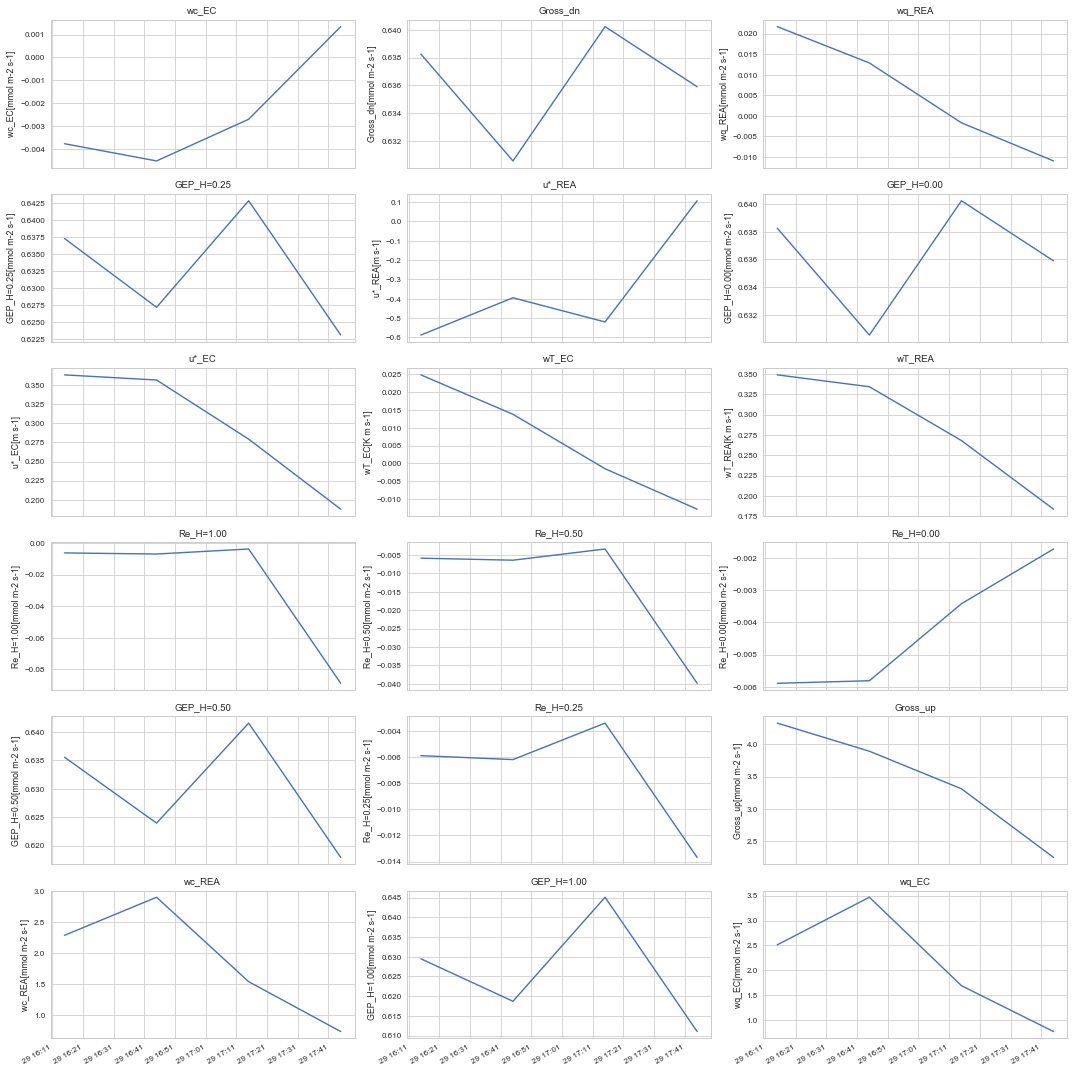

In [5]:
fig, axes = plt.subplots(6, 3, sharex=True, figsize=(15, 15))
axes = axes.flatten()
for n, obs in enumerate(obsItems):
    ax = axes[n]
    ax.plot(condFlux.index, condFlux[obs])
    ax.set_ylabel(obs + condFlux_units[obs])
    ax.set_title(obs)
fig.autofmt_xdate()
fig.tight_layout()


## Formatting the filestatistics

In [6]:
fStats = pd.read_csv('ExpMM_2017_land_2m_filestatistics_30min_3Drot_frc.csv',
                       header=[0, 1], delimiter=',', index_col=1, parse_dates=[1])

# Drop datetime_end column
fStats.drop(fStats.columns.values[1], axis=1, inplace=True)

# All columns are unitless, drop units row. I'm using a super hacky approach,
# it would be good to clean this up later.
fStats.rename(index=str, columns={fStats.columns[0]: 'Filename'}, inplace=True)
fStats.columns = [fS[0] for fS in fStats.columns]
fStats.rename(index=str, columns={fStats.columns[0]: 'Filename'}, inplace=True)

## Formatting QA/QC

In [7]:
qaqc = pd.read_csv('ExpMM_2017_land_2m_qaqc_30min_3Drot_frc.csv',
                   header=0, delimiter=',', index_col='Datetime_center')

# Drop unneeded columns
qaqc.drop(['Datetime_start', 'Datetime_end', 'DOY'], axis=1, inplace=True)
qaqc = qaqc.loc[:, ~qaqc.columns.str.contains('^Unnamed')]

# Save units as separate dictionary
qaqc_units = qaqc.iloc[0]
for qu in qaqc_units.keys():
    if '[1]' in qaqc_units[qu]:
        qaqc_units[qu] = 'unitless'
qaqc.drop([qaqc.index[0]], inplace=True)

print(qaqc)

                Latitude Coriolis_param f     u*      zeta uw_Stationarity  \
Datetime_center                                                              
736936.677083      54.52       0.00013840  0.350  -0.01246             9.1   
736936.697917      54.52       0.00013840  0.335  -0.00840             7.2   
736936.718750      54.52       0.00013840  0.269   0.00215             1.6   
736936.739583      54.52       0.00013840  0.184   0.04309             1.3   

                vw_Stationairty wTs_Stationarity wco2_irga1 Stationarity  \
Datetime_center                                                            
736936.677083              28.0             12.2                    18.6   
736936.697917             309.3             27.7                    13.8   
736936.718750              11.5             14.5                     1.1   
736936.739583              20.1              0.1                     4.7   

                wh2o_irga1 Stationarity    itc_u         ...           \
D

## Format results

In [8]:
results_cols = pd.read_csv('ExpMM_2017_land_2m_results_30min_3Drot_frc.csv',
                           header=0, delimiter=',', error_bad_lines=False)
results_units = results_cols.iloc[0]
results = pd.read_csv('ExpMM_2017_land_2m_results_30min_3Drot_frc.csv',
                      skiprows=[0,1], delimiter=',',
                      names=results_cols.columns.values, index_col=False, 
                      header=None)
results = results.reset_index(drop=True).set_index([matlabdn2datetime(results['Datetime_center'].values)])

# Drop unneeded columns
results.drop(['Datetime_start', 'Datetime_end', 'Datetime_center', 'DOY'], axis=1, inplace=True)

# Save units as separate dictionary
for ru in results_units.keys():
    if '[1]' in results_units[ru]:
        results_units[ru] = 'unitless'

print(results_units)

Datetime_start                 unitless
Datetime_end                   unitless
Datetime_center                unitless
DOY                            unitless
z_aero                              [m]
z_asl                               [m]
lat                               [deg]
lon                               [deg]
utc_offset                     unitless
zenith                            [deg]
azimuth                           [deg]
DayNightIndicator              unitless
#_data                         unitless
#_NaN_uvwTs                    unitless
#_NaN_irga1                    unitless
frc_#iterations                unitless
u_mean_unrot                    [m s-1]
u_std_unrot                     [m s-1]
u_skew_unrot                ([m s-1])^3
u_kurt_unrot                ([m s-1])^4
v_mean_unrot                    [m s-1]
v_std_unrot                     [m s-1]
v_skew_unrot                ([m s-1])^3
v_kurt_unrot                ([m s-1])^4
w_mean_unrot                    [m s-1]


b'Skipping line 3: expected 129 fields, saw 130\nSkipping line 4: expected 129 fields, saw 130\nSkipping line 5: expected 129 fields, saw 130\nSkipping line 6: expected 129 fields, saw 130\n'


In [14]:
ds = xr.Dataset.from_dataframe(results)

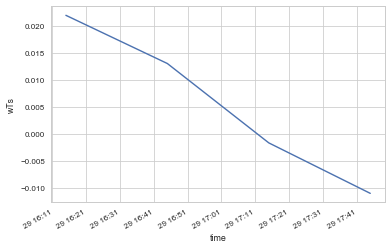

In [22]:
ds.wTs.plot()

In [24]:
ds.attrs = results_units

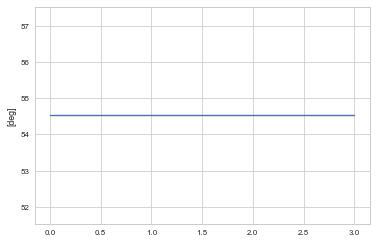

In [30]:
# Psuedo code
# for names in ds.names:
# Loop through names
plt.plot(ds['lat'])
plt.gca().set_ylabel(ds.attrs['lat'])

In [34]:
temp_ds = xr.Dataset({'lat', (['time','units'], np.atleast_2d(ds.lat.values))},
                     coords={'time': ds.time.values, 'units': ds.attrs['lat']})
print(temp_ds)

TypeError: unhashable type: 'list'